# ML. Начало.
Необходимо выполнить очередной чекпойнт, посвященный началу использования моделей машинного обучения для решения поставленной задачи.

Цель этого этапа – применить простые модели для решения вашей задачи

От вас требуется:
1) Выбрать ключевую метрику для оценки качества моделей, которую вы будете вычислять на протяжении всего процесса работы с моделями. Ключевая метрика, как правило, одна - она должна отражать особенности задачи и специфику данных. Выбор метрики - ответственный шаг, его необходимо подробно обсудить и согласовать с куратором. Помимо ключевой метрики можно измерять и вспомогательные метрики - но ориентир это ключевая метрика.
2) Применить простые модели машинного обучения для решения поставленной задачи:
3) Метрические подходы (KNN)
4) Линейные модели регрессии или классификации, в зависимости от поставленной задачи
Оценить качество обученных моделей с помощью выбранной метрики (метрик)
Подобрать гиперпараметры моделей и подумать над feature engineerging для улучшения качества прогнозов с точки зрения выбранных метрик. Провести эксперименты.
5) Написать выводы по проделанной работе

Выполнение этого чекпойнта будет проверяться кураторами.

Обучение моделей проводится в python, исследования и выводы проделайте в файле `ML.ipynb`, файл выложите на гитхаб.

In [ ]:
import re
import warnings 

import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas as pd

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from scipy.sparse import hstack, csr_matrix

import phik
from phik import phik_matrix

warnings.filterwarnings("ignore")

random_state = 42

In [19]:
df_path = 'dump_features_include_numeric.csv'
df = pd.read_csv(df_path, index_col=0)
display(df)

# select data from the cleanest datasets (0, 1) to train: 
df_train = df[(df['dataset_id']==0) | (df['dataset_id']==1)]
df_train.dropna(subset='is_toxic', inplace=True)

# select data from the same source (vk), with the best results that BERT classifier predicted: 
df_test = df[df['dataset_id']==7]

n_test_add = 60000 
df_test = pd.concat(
    [
    df_test, 
    df[(df['dataset_id']==2) | (df['dataset_id']==3) | (df['dataset_id']==4) | (df['dataset_id']==5)].dropna(subset='is_toxic').sample(
        n=n_test_add,
        random_state=random_state)
    ]
    )

print(f'df_train shape: {df_train.shape}')
print(f'df_test shape: {df_test.shape}')

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type,text_encoded_noninfrm,text_encoded_emoj_emotic,text_encoded_punct,...,is_bad_word_incl,has_pronouns,starts_with_cap,ends_with_dot,has_emotional_sym,has_repeating_letters_3plus,has_url,has_number,has_mention,has_hashtag
0,0,0,"2ch, pikabu",1,"Верблюдов-то за что? Дебилы, бл...\n",1.0,NaN,"Верблюдов-то за что? Дебилы, бл...","Верблюдов-то за что? Дебилы, бл...",Верблюдов[SPP_0]то за что[SPP_1] Дебилы[SPP_2]...,...,0,0,1,0,0,0,0,0,0,0
1,1,0,"2ch, pikabu",1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,NaN,"Хохлы, это отдушина затюканого россиянина, мол...","Хохлы, это отдушина затюканого россиянина, мол...",Хохлы[SPP_2] это отдушина затюканого россиянин...,...,0,0,1,1,0,0,0,0,0,0
2,2,0,"2ch, pikabu",1,Собаке - собачья смерть\n,1.0,NaN,Собаке - собачья смерть,Собаке - собачья смерть,Собаке [SPP_0] собачья смерть,...,0,0,1,0,0,0,0,0,0,0
3,3,0,"2ch, pikabu",1,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,NaN,"Страницу обнови, дебил. Это тоже не оскорблени...","Страницу обнови, дебил. Это тоже не оскорблени...",Страницу обнови[SPP_2] дебил[SPP_3] Это тоже н...,...,0,0,1,0,0,0,0,0,0,0
4,4,0,"2ch, pikabu",1,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,NaN,"тебя не убедил [NUM]-страничный пдф в том, что...","тебя не убедил [NUM]-страничный пдф в том, что...",тебя не убедил [NUM][SPP_0]страничный пдф в то...,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455550,455550,7,"Social Media, TV-Scripts (South Park)",0,"Fox News сообщил о работе Трампа в выходные, н...",0.0,NaN,"Fox News сообщил о работе Трампа в выходные, н...","Fox News сообщил о работе Трампа в выходные, н...",Fox News сообщил о работе Трампа в выходные[SP...,...,0,0,1,0,0,0,0,0,0,0
455551,455551,7,"Social Media, TV-Scripts (South Park)",0,Открыто новое достижение- выжил в России https...,0.0,NaN,Открыто новое достижение- выжил в России [URL],Открыто новое достижение- выжил в России [URL],Открыто новое достижение[SPP_0] выжил в России...,...,0,0,1,0,0,0,1,0,0,0
455552,455552,7,"Social Media, TV-Scripts (South Park)",0,"Митинговал ты, а страдает Пушкин https://t.co/...",0.0,NaN,"Митинговал ты, а страдает Пушкин [URL]","Митинговал ты, а страдает Пушкин [URL]",Митинговал ты[SPP_2] а страдает Пушкин [URL],...,0,0,1,0,0,0,1,0,0,0
455553,455553,7,"Social Media, TV-Scripts (South Park)",0,"'@max_katz Полицейское государство, в котором ...",1.0,NaN,"'[MNT] Полицейское государство, в котором не д...","'[MNT] Полицейское государство, в котором не д...",[RPP_483]MNT] Полицейское государство[SPP_2] в...,...,0,0,1,0,0,0,0,0,0,0


df_train shape: (252117, 34)
df_test shape: (61455, 34)


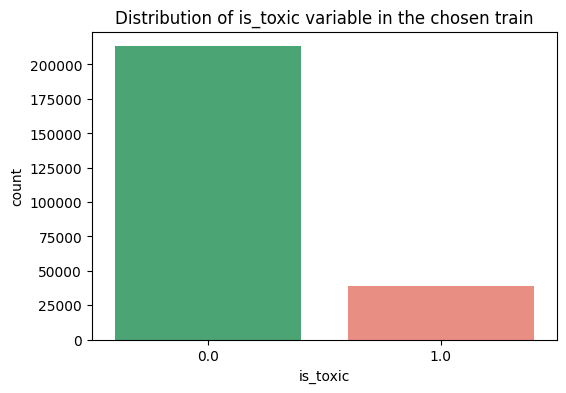

In [20]:
# count train is_toxic distribution:
plt.figure(figsize=(6,4))
sns.countplot(x='is_toxic', data=df_train.dropna(subset='is_toxic'), palette=['mediumseagreen','salmon'])
plt.title('Distribution of is_toxic variable in the chosen train')
plt.show()

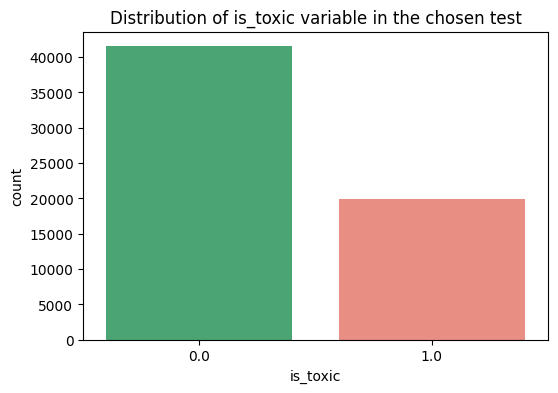

In [21]:
# count test is_toxic distribution:
plt.figure(figsize=(6,4))
sns.countplot(x='is_toxic', data=df_test, palette=['mediumseagreen','salmon'])
plt.title('Distribution of is_toxic variable in the chosen test')
plt.show()

# 1. Метрики

В качестве основной метрики была выбрана метрика `macro f1-score`
(не зависит от размеров классов, будут видны проблемы при работе с мелкими классами).

Дополнительно были рассмотрены 
- `micro f1-score`,
- `weighted_f1`, 
- `accuracy`, 
- `precision`/`recall` по классам
- `ROC-AUC`

In [22]:
def calculate_all_metrics(y_true, y_pred, y_pred_proba=None):
    metrics = {}
    
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['macro_f1'] = f1_score(y_true, y_pred, average='macro')
    metrics['micro_f1'] = f1_score(y_true, y_pred, average='micro')
    metrics['weighted_f1'] = f1_score(y_true, y_pred, average='weighted')
    
    metrics['macro_precision'] = precision_score(y_true, y_pred, average='macro')
    metrics['macro_recall'] = recall_score(y_true, y_pred, average='macro')
    
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    metrics['class_0_precision'] = precision_per_class[0]
    metrics['class_0_recall'] = recall_per_class[0]
    metrics['class_0_f1'] = f1_per_class[0]
    metrics['class_1_precision'] = precision_per_class[1]
    metrics['class_1_recall'] = recall_per_class[1]
    metrics['class_1_f1'] = f1_per_class[1]
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba[:, 1])
    
    return metrics

def print_metrics(metrics, title='Метрики'):
    available_space = 100
    print('-' * available_space)
    print(title)
    print(f'macro f1-score: { metrics.get("macro_f1", "-") }')
    print('-' * available_space)

    print(f'accuracy: { metrics.get("accuracy", "-") }')
    print(f'micro f1-score: { metrics.get("micro_f1", "-") }')
    print(f'weighted f1-score: { metrics.get("weighted_f1", "-") }')
    print(f'macro precision: { metrics.get("macro_precision", "-") }')
    print(f'macro recall: { metrics.get("macro_recall", "-") }')
    
    if 'roc_auc' in metrics:
        print(f'ROC-AUC: {metrics["roc_auc"]}')
    
    print(f'\nМетрики по классам:')
    print(f'   non-toxic(0): Precision={metrics.get("class_0_precision", "-")}, '
          f'Recall={metrics.get("class_0_recall", "-")}, F1={metrics.get("class_0_f1", "-")}')
    print(f'   toxic(0): Precision={metrics.get("class_1_precision", "-")}, '
          f'Recall={metrics.get("class_1_recall", "-")}, F1={metrics.get("class_1_f1", "-")}')
    
    print('-' * available_space)

# 3. Применение моделей машинного обучения

In [23]:
def train_and_test_models_enhanced(
        train_texts: pd.Series,
        train_targets: pd.Series,
        train_num_features: pd.DataFrame,
        test_texts: pd.Series,
        test_targets: pd.Series,
        test_num_features: pd.DataFrame,
        use_num_features: bool = True,
        texts_col: str = '',
        downsample: bool = False,
    ):
    
    print(f'params:')
    print(f' - use_num_features: {use_num_features}')
    print(f' - texts_col: {texts_col}')
    print(f' - downsample: {downsample}')
    
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.9
    )
    X_train_tfidf = vectorizer.fit_transform(train_texts)
    X_test_tfidf = vectorizer.transform(test_texts)
    
    print(f' - tf-idf matrix size: {X_train_tfidf.shape}')
    
    if use_num_features:
        train_num_features, test_num_features = train_num_features.align(
            test_num_features, axis=1, join="left", fill_value=0
        )
        
        train_num_sparse = csr_matrix(train_num_features.values)
        test_num_sparse = csr_matrix(test_num_features.values)
        
        X_train = hstack([X_train_tfidf, train_num_sparse])
        X_test = hstack([X_test_tfidf, test_num_sparse])
        
        print(f' - train matrix size with num features: {X_train.shape}')
    else:
        X_train = X_train_tfidf
        X_test = X_test_tfidf

    models = {
        'Logistic Regression': LogisticRegression(random_state=random_state),
        'Linear SVM (LinearSVC)': LinearSVC(random_state=random_state, max_iter=2000),
        'SGD Classifier': SGDClassifier(random_state=random_state, max_iter=1000),

        'KNN (k=3, cosine)': KNeighborsClassifier(n_neighbors=3, metric='cosine'),
        'KNN (k=7, cosine)': KNeighborsClassifier(n_neighbors=7, metric='cosine'),
        'KNN (k=15, cosine)': KNeighborsClassifier(n_neighbors=15, metric='cosine'),
        
        'KNN (k=7, cosine)': KNeighborsClassifier(n_neighbors=5, metric='cosine'),
        'KNN (k=7, euclidean)': KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
        'KNN (k=7, manhattan)': KNeighborsClassifier(n_neighbors=5, metric='manhattan'),
    }
    
    results = []
    
    for name, model in models.items():
        print(f'\nобучение {name}')
        
        model.fit(X_train, train_targets)
        preds = model.predict(X_test)
        
        try:
            pred_proba = model.predict_proba(X_test)
        except:
            pred_proba = None
        
        metrics = calculate_all_metrics(test_targets, preds, pred_proba)
        
        record = {
            'model': name,
            'use_num_features': use_num_features, 
            'texts_col': texts_col,
            'downsampled_to_equals': downsample           
        }
        record.update(metrics)
        results.append(record)
        
        print_metrics(metrics, name)
    
    return results

In [24]:
target_col = 'is_toxic'

composed_features = [
    'count_spp', 'count_rpp', 'punct_after_space', 'has_emoji', 'has_emoticon',
    'has_capslock', 'is_all_lower', 'has_punctuation_spp', 'has_punctuation_rpp',
    'has_fence_ironic_style', 'count_profanity', 'has_pronouns', 'starts_with_cap',
    'has_url', 'has_number', 'has_mention', 'has_hashtag', 'ends_with_dot',
    'has_emotional_sym', 'has_repeating_letters_3plus'
]

print(f'\nДоступные числовые признаки: { composed_features}')

missing_features = [f for f in composed_features if f not in df.columns]
if missing_features:
    print(f'missing_features: {missing_features}')

text_columns = ['text_raw', 'text_encoded_profanity', 'text_del_stop_words', 'text_without_tokens']
available_text_cols = [col for col in text_columns if col in df.columns]
print(f'\nДоступные текстовые колонки: {available_text_cols}')


Доступные числовые признаки: ['count_spp', 'count_rpp', 'punct_after_space', 'has_emoji', 'has_emoticon', 'has_capslock', 'is_all_lower', 'has_punctuation_spp', 'has_punctuation_rpp', 'has_fence_ironic_style', 'count_profanity', 'has_pronouns', 'starts_with_cap', 'has_url', 'has_number', 'has_mention', 'has_hashtag', 'ends_with_dot', 'has_emotional_sym', 'has_repeating_letters_3plus']

Доступные текстовые колонки: ['text_raw', 'text_encoded_profanity', 'text_del_stop_words', 'text_without_tokens']


In [25]:
def run_experiment(configurations):
    results = []
    for i, config in enumerate(configurations, 1):
        available_space = 70
        print('-' * available_space)
        print(f'configuration - {i}/{len(configurations)}')
        print(f'configurations: {config}')
        print('-' * available_space)
        
        use_num = config['use_num']
        downsample = config['downsample']
        texts_col = config['text_col']
        
        if texts_col not in df.columns:
            print(f'{texts_col} not found')
            continue
        
        if downsample:
            n_1_train = df_train[df_train['is_toxic'] == 1].shape[0]
            df_0_train = df_train[df_train['is_toxic'] == 0]
            df_1_train = df_train[df_train['is_toxic'] == 1]
            df_0_down_train = df_0_train.sample(n=n_1_train, random_state=42)
            df_train_exp = pd.concat([df_0_down_train, df_1_train], axis=0)
            
            n_1_test = df_test[df_test['is_toxic'] == 1].shape[0]
            df_0_test = df_test[df_test['is_toxic'] == 0]
            df_1_test = df_test[df_test['is_toxic'] == 1]
            df_0_down_test = df_0_test.sample(n=n_1_test, random_state=42)
            df_test_exp = pd.concat([df_0_down_test, df_1_test], axis=0)
        else:
            df_train_exp = df_train.copy()
            df_test_exp = df_test.copy()
        
        df_train_clean = df_train_exp.dropna(subset=composed_features + [texts_col]).copy()
        df_test_clean = df_test_exp.dropna(subset=composed_features + [texts_col]).copy()
        
        print(f'sizes: train - {df_train_clean.shape}, test - {df_test_clean.shape}')
        
        train_texts = df_train_clean[texts_col]
        train_targets = df_train_clean[target_col]
        train_num_features = df_train_clean[composed_features]
        
        test_texts = df_test_clean[texts_col]
        test_targets = df_test_clean[target_col]
        test_num_features = df_test_clean[composed_features]
        
        experiment_results = train_and_test_models_enhanced(
            train_texts, train_targets, train_num_features,
            test_texts, test_targets, test_num_features,
            use_num_features=use_num,
            texts_col=texts_col,
            downsample=downsample
        )
        results.extend(experiment_results)
    
    return results

In [26]:
configurations_text_raw = [
    {'use_num': True, 'downsample': False, 'text_col': 'text_raw'},
    {'use_num': False, 'downsample': False, 'text_col': 'text_raw'},
    {'use_num': True, 'downsample': True, 'text_col': 'text_raw'},
    {'use_num': False, 'downsample': True, 'text_col': 'text_raw'},
]

results = []

results.extend(run_experiment(configurations_text_raw))

----------------------------------------------------------------------
configuration - 1/4
configurations: {'use_num': True, 'downsample': False, 'text_col': 'text_raw'}
----------------------------------------------------------------------
sizes: train - (252117, 34), test - (61455, 34)
params:
 - use_num_features: True
 - texts_col: text_raw
 - downsample: False
 - tf-idf matrix size: (252117, 179774)
 - train matrix size with num features: (252117, 179794)

обучение Logistic Regression
----------------------------------------------------------------------------------------------------
Logistic Regression
macro f1-score: 0.8354757976170206
----------------------------------------------------------------------------------------------------
accuracy: 0.8652672687332195
micro f1-score: 0.8652672687332195
weighted f1-score: 0.8601043706758367
macro precision: 0.8695743353924517
macro recall: 0.8166324806734697
ROC-AUC: 0.8850782357459746

Метрики по классам:
   non-toxic(0): Precision=0.

In [ ]:
configurations_text_nonraw = [
    {'use_num': True, 'downsample': False, 'text_col': 'text_del_stop_words'},
    {'use_num': True, 'downsample': False, 'text_col': 'text_encoded_profanity'},
    {'use_num': True, 'downsample': False, 'text_col': 'text_without_tokens'},
]

results.extend(run_experiment(configurations_text_nonraw))

----------------------------------------------------------------------
configuration - 1/3
configurations: {'use_num': True, 'downsample': False, 'text_col': 'text_del_stop_words'}
----------------------------------------------------------------------
sizes: train - (251635, 34), test - (61374, 34)
params:
 - use_num_features: True
 - texts_col: text_del_stop_words
 - downsample: False
 - tf-idf matrix size: (251635, 170144)
 - train matrix size with num features: (251635, 170164)

обучение Logistic Regression
----------------------------------------------------------------------------------------------------
Logistic Regression
macro f1-score: 0.8472238371669991
----------------------------------------------------------------------------------------------------
accuracy: 0.8759735392837358
micro f1-score: 0.8759735392837358
weighted f1-score: 0.8704836247118649
macro precision: 0.8891943679452761
macro recall: 0.8253939390114535
ROC-AUC: 0.8894702744299692

Метрики по классам:
   non-

In [34]:
results_df = pd.DataFrame(results).sort_values('macro_f1', ascending=False)

print('Результаты:')

top_results = results_df.head(20)
display_cols = ['model', 'macro_f1', 'accuracy', 'micro_f1', 'use_num_features', 'texts_col', 'downsampled_to_equals']
print(top_results[display_cols])

print('-' * 100)
best_result = results_df.iloc[0]

print(f'Лучший результат - {best_result["model"]}')
print(f'\nmacro f1-score: {best_result["macro_f1"]}')
print(f'accuracy: {best_result["accuracy"]}')
print(f'macro_precision: {best_result["macro_precision"]}')
print(f'macro_recall: {best_result["macro_recall"]}')
print(f'use_num_features: {best_result["use_num_features"]}')
print(f'texts_col: {best_result["texts_col"]}')
print(f'downsampled_to_equals: {best_result["downsampled_to_equals"]}')


Результаты:
                     model  macro_f1  accuracy  micro_f1  use_num_features  \
33  Linear SVM (LinearSVC)  0.862931  0.885619  0.885619              True   
41  Linear SVM (LinearSVC)  0.858948  0.882158  0.882158              True   
1   Linear SVM (LinearSVC)  0.851826  0.877504  0.877504              True   
49  Linear SVM (LinearSVC)  0.851723  0.876775  0.876775              True   
50          SGD Classifier  0.848110  0.877768  0.877768              True   
32     Logistic Regression  0.847224  0.875974  0.875974              True   
34          SGD Classifier  0.844746  0.875175  0.875175              True   
48     Logistic Regression  0.844527  0.873876  0.873876              True   
42          SGD Classifier  0.839509  0.870019  0.870019              True   
2           SGD Classifier  0.838696  0.871141  0.871141              True   
0      Logistic Regression  0.835476  0.865267  0.865267              True   
40     Logistic Regression  0.830087  0.860939  0.86

подберем наилучшие параметры для `Linear SVM (LinearSVC)`

In [38]:
base_model = LinearSVC(random_state=random_state, max_iter=2000)
param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': [None, 'balanced'],
}

print(f'\nparams: {param_grid}')

texts_col = best_result['texts_col']
df_train_clean = df_train.copy().dropna(subset=composed_features + [texts_col]).copy()

train_texts = df_train_clean[texts_col]
train_targets = df_train_clean[target_col]
train_num_features = df_train_clean[composed_features]

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)
X_train_tfidf = vectorizer.fit_transform(train_texts)

train_num_sparse = csr_matrix(train_num_features.values)
X_train_final = hstack([X_train_tfidf, train_num_sparse])

grid_search = GridSearchCV(
    base_model, 
    param_grid, 
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X_train_final, train_targets)

print(f'best params: {grid_search.best_params_}')
print(f'best macro f1-score: {grid_search.best_score_}')
print(f'diff: {grid_search.best_score_ - best_result["macro_f1"]}')
        


params: {'C': [0.1, 1.0, 10.0, 100.0], 'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge'], 'class_weight': [None, 'balanced']}
Fitting 3 folds for each of 32 candidates, totalling 96 fits
best params: {'C': 1.0, 'class_weight': None, 'loss': 'squared_hinge', 'penalty': 'l1'}
best macro f1-score: 0.906324383409146
diff: 0.04339370755172245


# Лучший результат
- Модель - `Linear SVM (LinearSVC) `.
- `macro f1-score` - `0.8629` → `0.9063` (после оптимизации).
- использовались `TF-IDF` + числовые признаки + `text_del_stop_words` (тексты с удаленными стоп-словами).

# Выводы 
1. Числовые признаки важны. Их добавление дало существенный прирост к `macro f1-score`.
2. Удаление стоп-слов действительно улучшает результат.
3. `Linear SVM` показал лучшую производительность среди всех моделей.
4. `GridSearchCV` дал значительное улучшение: `+0.04` к базовому результату.

Таким образом, была получена эффективная модель для классификации токсичных сообщений с `macro f1-score` = 0.9063, что является отличным результатом для текущей задачи.